/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWa

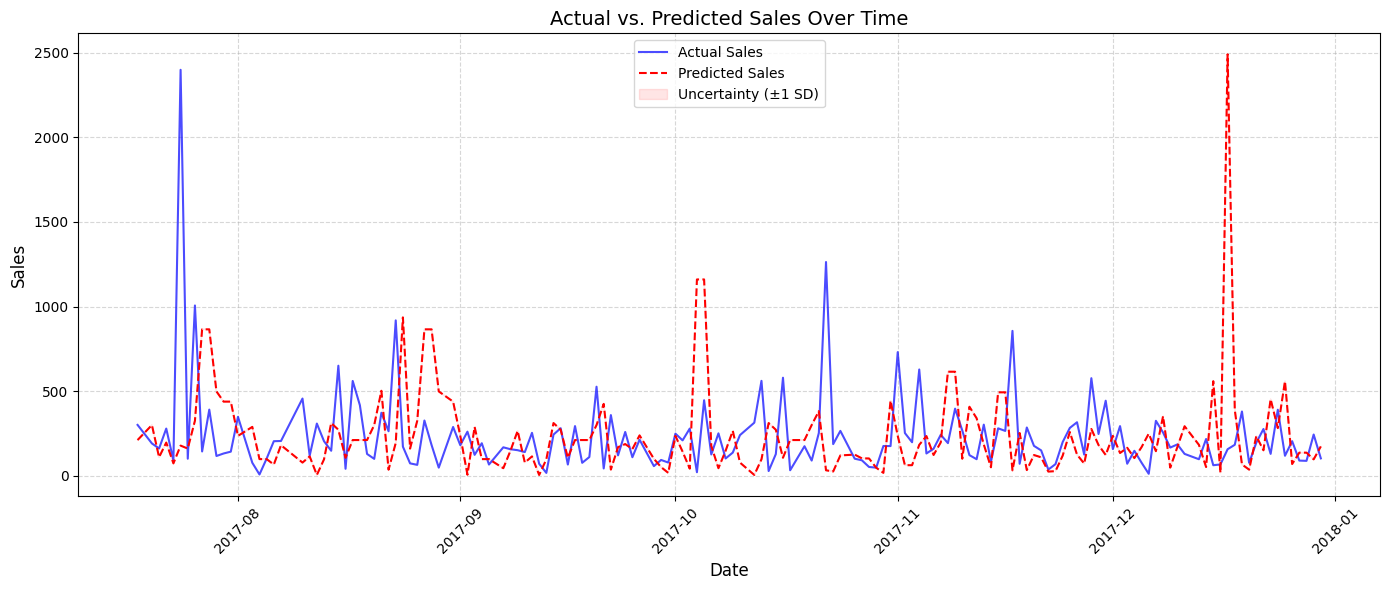

In [6]:
# Predict on test set (using all trees)
preds = np.array([tree.predict(X_test) for tree in model.estimators_])  # Shape: (100 trees, 1999 samples)

# Convert to DataFrame and merge with dates
preds_df = pd.DataFrame(preds.T, index=X_test.index)  # 1999 rows × 100 trees
preds_df['Order Date'] = plot_df['Order Date']  # Add dates from the test set

# Aggregate predictions by date (mean and std)
preds_agg = preds_df.groupby('Order Date').agg(['mean', 'std'])

# Fix: Convert MultiIndex columns to strings before joining
preds_agg.columns = ['_'.join(map(str, col)).strip() for col in preds_agg.columns]

# Merge with plot_agg
plot_agg = plot_agg.merge(preds_agg, left_on='Order Date', right_index=True)

# Plot with corrected confidence intervals
plt.figure(figsize=(14, 6))
plt.plot(plot_agg['Order Date'], plot_agg['Sales'], label='Actual Sales', color='blue', alpha=0.7)
plt.plot(plot_agg['Order Date'], plot_agg['0_mean'], label='Predicted Sales', color='red', linestyle='--')

# Use aggregated std from preds_agg
plt.fill_between(plot_agg['Order Date'],
                 plot_agg['0_mean'] - plot_agg['0_std'],
                 plot_agg['0_mean'] + plot_agg['0_std'],
                 color='red', alpha=0.1, label='Uncertainty (±1 SD)')

# Formatting
plt.title('Actual vs. Predicted Sales Over Time', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Sales', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

[0]	train-rmse:608.49507


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:53:16] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "early_stopping_rounds", "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[100]	train-rmse:106.25724
[200]	train-rmse:69.05508
[300]	train-rmse:46.72544
[400]	train-rmse:31.23784
[500]	train-rmse:21.69336
[600]	train-rmse:15.48129
[700]	train-rmse:11.20267
[800]	train-rmse:8.15066
[900]	train-rmse:5.97013
[1000]	train-rmse:4.42546
[1100]	train-rmse:3.38507
[1200]	train-rmse:2.61779
[1300]	train-rmse:2.03391
[1400]	train-rmse:1.59317
[1500]	train-rmse:1.25909
[1600]	train-rmse:0.99880
[1700]	train-rmse:0.80690
[1800]	train-rmse:0.64755
[1900]	train-rmse:0.51957
[1999]	train-rmse:0.42817


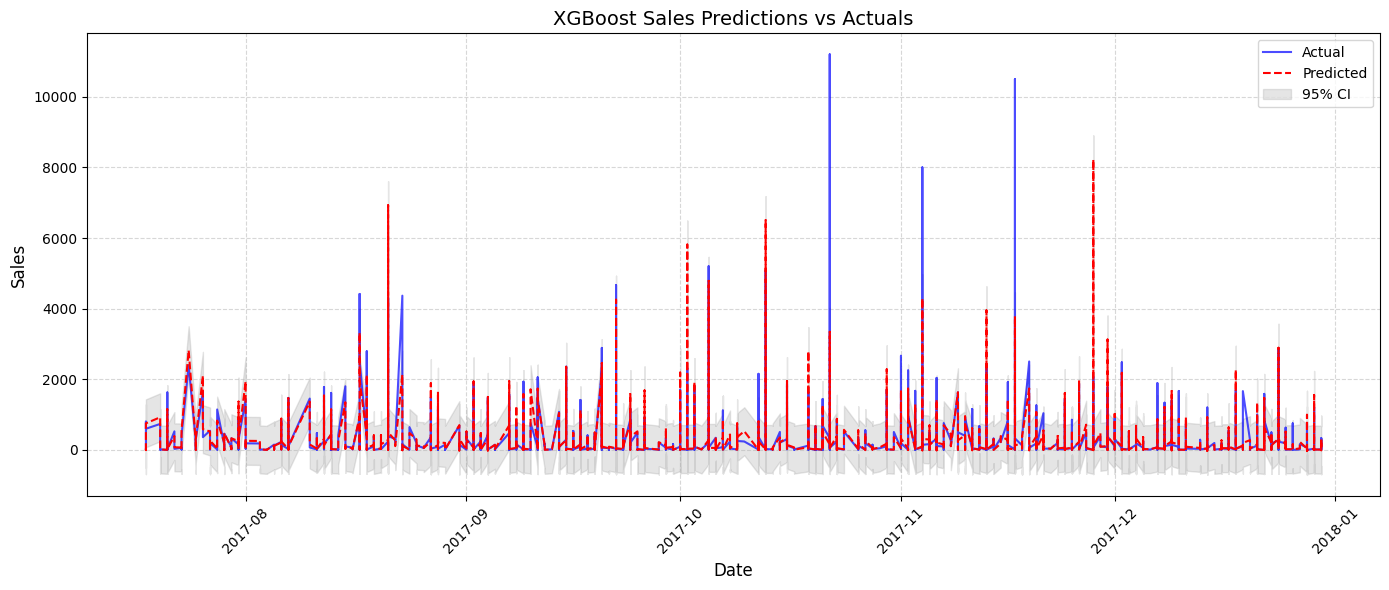

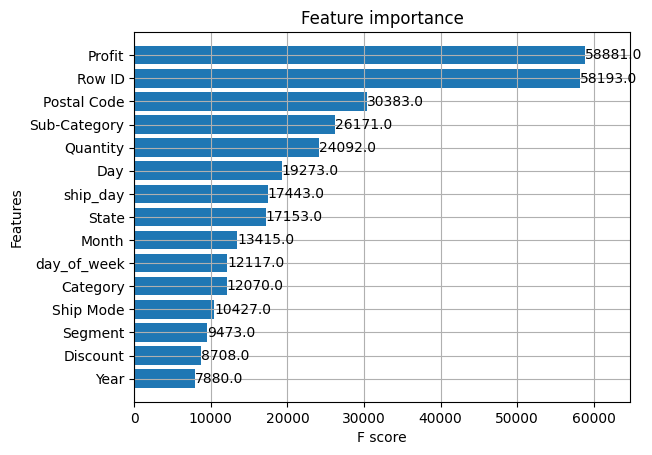

In [8]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Convert date columns to datetime
df['Order Date'] = pd.to_datetime(df['Order Date'])
df['Ship Date'] = pd.to_datetime(df['Ship Date'])

# Feature engineering
df['order_year'] = df['Order Date'].dt.year
df['order_month'] = df['Order Date'].dt.month
df['order_day'] = df['Order Date'].dt.day
df['ship_year'] = df['Ship Date'].dt.year
df['ship_month'] = df['Ship Date'].dt.month
df['ship_day'] = df['Ship Date'].dt.day

# Drop non-essential columns
df = df.drop(['Order ID', 'Ship Date', 'Customer ID', 'Customer Name',
              'Country', 'City', 'Product ID', 'Product Name'], axis=1)

# Encode categorical variables
cat_cols = ['Ship Mode', 'Segment', 'State', 'Region', 'Category', 'Sub-Category']
le = LabelEncoder()
for col in cat_cols:
    df[col] = le.fit_transform(df[col])

# Prepare data
X = df.drop(['Sales', 'Order Date'], axis=1)
y = df['Sales']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Convert to DMatrix
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test)

# XGBoost parameters
params = {
    'objective': 'reg:squarederror',
    'learning_rate': 0.05,
    'max_depth': 8,
    'subsample': 0.8,
    'colsample_bytree': 0.9,
    'n_estimators': 2000,
    'random_state': 42,
    'early_stopping_rounds': 50
}

# Train model
model = xgb.train(
    params,
    dtrain,
    num_boost_round=2000,
    evals=[(dtrain, 'train')],
    verbose_eval=100
)

# Generate predictions
preds = model.predict(dtest)

# Create results dataframe
results = pd.DataFrame({
    'Actual': y_test.values,
    'Predicted': preds,
    'Order Date': df.loc[y_test.index, 'Order Date']
})

# Calculate residuals and confidence intervals
results['Residuals'] = results['Actual'] - results['Predicted']
std_dev = results['Residuals'].std()
results['Upper'] = results['Predicted'] + 1.96 * std_dev
results['Lower'] = results['Predicted'] - 1.96 * std_dev

# Plot results
plt.figure(figsize=(14, 6))
plt.plot(results['Order Date'], results['Actual'], label='Actual', color='blue', alpha=0.7)
plt.plot(results['Order Date'], results['Predicted'], label='Predicted', color='red', linestyle='--')
plt.fill_between(results['Order Date'], results['Lower'], results['Upper'],
                 color='gray', alpha=0.2, label='95% CI')

plt.title('XGBoost Sales Predictions vs Actuals', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Sales', fontsize=12)
plt.legend()
plt.grid(linestyle='--', alpha=0.5)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Feature importance
xgb.plot_importance(model, height=0.8, max_num_features=15)
plt.show()